In [1]:
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import sys
import math
import random
import warnings
import ast
!pip install timm==0.4.5 torchlibrosa pytorch-lightning==1.3.4
!pip install wget
import wget

import albumentations as A
import matplotlib.pyplot as plt
import cv2
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import timm
from timm.models.layers import to_2tuple,trunc_normal_
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

from pathlib import Path
from typing import List

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import wandb
from pytorch_lightning.loggers import WandbLogger

from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform
from sklearn import model_selection
from sklearn import metrics
from timm.models.layers import SelectAdaptivePool2d
from torch.optim.optimizer import Optimizer
from torchlibrosa.stft import LogmelFilterBank, Spectrogram
from torchlibrosa.augmentation import SpecAugmentation
import torchaudio
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb-api-key")
wandb.login(key=secret_value_0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 KB 934.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.4/806.4 KB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 KB 16.3 MB/s eta 0:00:0000:01
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: pyDeprecate
    Found existing installation: pyDeprecate 0.3.2
    Uninstalling pyDeprecate-0.3.2:
      Successfully uninstalled pyDeprecate-0.3.2
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.6.0
    Uninstalling pytorch-lightning-1.6.0:
      Successfully uninstalled pytorch-lightning-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, wh

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
!wget https://zenodo.org/record/3987831/files/Cnn14_mAP%3D0.431.pth?download=1

--2022-05-03 04:43:50--  https://zenodo.org/record/3987831/files/Cnn14_mAP%3D0.431.pth?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327428481 (312M) [application/octet-stream]
Saving to: ‘Cnn14_mAP=0.431.pth?download=1’

Cnn14_mAP=0.431.pth 100%[===================>] 312.26M   102MB/s    in 3.1s    

2022-05-03 04:43:55 (102 MB/s) - ‘Cnn14_mAP=0.431.pth?download=1’ saved [327428481/327428481]



In [3]:
!ls -lrth

total 313M
-rw-r--r-- 1 root root 313M Apr 18 13:38 'Cnn14_mAP=0.431.pth?download=1'
---------- 1 root root  263 May  3 04:42  __notebook_source__.ipynb


In [4]:
checkpoint_path = "Cnn14_mAP=0.431.pth?download=1"

In [5]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["CUDA_LAUNCH_BLOCKING"]="1"
    os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.use_deterministic_algorithms = True
    torch.backends.cudnn.benchmark = False  # type: ignore

In [8]:
class CFG:
    exp_num = 14
    seed = 777
    epochs = 40
    train = True
    folds = [0]
    img_size = 224

    period = 10
    n_mels = 64
    fmin = 50
    fmax = 14000
    n_fft = 1024
    hop_length = 320
    sample_rate = 32000
    melspectrogram_parameters = {
        "n_mels": 224,
        "fmin": 20,
        "fmax": 16000
    }

    target_columns = [
        'afrsil1', 'akekee', 'akepa1', 'akiapo', 'akikik', 'amewig',
       'aniani', 'apapan', 'arcter', 'barpet', 'bcnher', 'belkin1',
       'bkbplo', 'bknsti', 'bkwpet', 'blkfra', 'blknod', 'bongul',
       'brant', 'brnboo', 'brnnod', 'brnowl', 'brtcur', 'bubsan',
       'buffle', 'bulpet', 'burpar', 'buwtea', 'cacgoo1', 'calqua',
       'cangoo', 'canvas', 'caster1', 'categr', 'chbsan', 'chemun',
       'chukar', 'cintea', 'comgal1', 'commyn', 'compea', 'comsan',
       'comwax', 'coopet', 'crehon', 'dunlin', 'elepai', 'ercfra',
       'eurwig', 'fragul', 'gadwal', 'gamqua', 'glwgul', 'gnwtea',
       'golphe', 'grbher3', 'grefri', 'gresca', 'gryfra', 'gwfgoo',
       'hawama', 'hawcoo', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1',
       'hoomer', 'houfin', 'houspa', 'hudgod', 'iiwi', 'incter1',
       'jabwar', 'japqua', 'kalphe', 'kauama', 'laugul', 'layalb',
       'lcspet', 'leasan', 'leater1', 'lessca', 'lesyel', 'lobdow',
       'lotjae', 'madpet', 'magpet1', 'mallar3', 'masboo', 'mauala',
       'maupar', 'merlin', 'mitpar', 'moudov', 'norcar', 'norhar2',
       'normoc', 'norpin', 'norsho', 'nutman', 'oahama', 'omao', 'osprey',
       'pagplo', 'palila', 'parjae', 'pecsan', 'peflov', 'perfal',
       'pibgre', 'pomjae', 'puaioh', 'reccar', 'redava', 'redjun',
       'redpha1', 'refboo', 'rempar', 'rettro', 'ribgul', 'rinduc',
       'rinphe', 'rocpig', 'rorpar', 'rudtur', 'ruff', 'saffin', 'sander',
       'semplo', 'sheowl', 'shtsan', 'skylar', 'snogoo', 'sooshe',
       'sooter1', 'sopsku1', 'sora', 'spodov', 'sposan', 'towsol',
       'wantat1', 'warwhe1', 'wesmea', 'wessan', 'wetshe', 'whfibi',
       'whiter', 'whttro', 'wiltur', 'yebcar', 'yefcan', 'zebdov']

    loader_params = {
        "train": {
            'batch_size': 10,
            'shuffle': True,
            'num_workers': 4,
            'pin_memory': True,
            'drop_last': True,
        },
        "valid": {
            'batch_size': 2,
            'shuffle': False,
            'num_workers': 4,
            'pin_memory': True,
            'drop_last': False,
        }
    }

    split = "StratifiedKFold"
    split_params = {
        "n_splits": 5,
        "shuffle": True,
        "random_state": 777
    }
    
    base_model_name = ""
    pooling = "max"
    pretrained = True
    num_classes = 152
    in_channels = 1

    optimizer_name = "Adam"
    base_optimizer = "Adam"
    optimizer_params = {
        "lr": 1e-4,
    }
    
    scheduler_name = "CosineAnnealingLR"
    scheduler_params = {
        "T_max": 10
    }

In [9]:
CFG = CFG()
os.environ['TORCH_HOME'] = './'

In [10]:
device = torch.device("cuda")
device

device(type='cuda')

## Config

In [11]:
DATA_DIR = Path("../input/")
MAIN_DATA_DIR = DATA_DIR / 'birdclef-2022/'
OUTPUT_DIR = Path('./')

In [12]:
######################
# Data #
######################
train_datadir = MAIN_DATA_DIR / 'train_audio'
train_csv = MAIN_DATA_DIR / 'train_metadata.csv'

In [13]:
DEBUG = False
if DEBUG:
    CFG.epochs = 1

## My func

In [14]:
class WaveformDataset(torchdata.Dataset):
    def __init__(self,
                 df: pd.DataFrame,
                 datadir: Path,
                 img_size=224,
                 period=10,
                 validation=False,
                 test=False):
        self.df = df
        self.datadir = datadir
        self.img_size = img_size
        self.period = period
        self.validation = validation
        self.test = test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        if ~self.test:
            sample = self.df.loc[idx, :]
            wav_name = sample["filename"]
            ebird_code = sample["primary_label"]
            primary_label = sample["primary_labels"]
            secondary_labels = sample["secondary_labels"]
            y, sr = sf.read(self.datadir / wav_name)
            y = np.array(y)
            if len(y.shape) == 2:
                y = np.mean(y, axis=1)

            len_y = len(y)
            effective_length = sr * self.period
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                if not self.validation:
                    start = np.random.randint(effective_length - len_y)
                else:
                    start = 0
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                if not self.validation:
                    start = np.random.randint(len_y - effective_length)
                else:
                    start = 0
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

            y = np.nan_to_num(y)

            labels = primary_label
            labels = labels.astype(np.float32)

            return {
                "image": y,
                "targets": labels
            }
        
        else:
            sample = self.df.loc[idx, :]
            print(sample)

## Model

In [15]:
def init_layer(layer):
    """Initialize a Linear or Convolutional layer. """
    nn.init.xavier_uniform_(layer.weight)
 
    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
            
    
def init_bn(bn):
    """Initialize a Batchnorm layer. """
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.)

In [16]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super(ConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.conv2 = nn.Conv2d(in_channels=out_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()
        
    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

        
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):
        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')
        
        return x


class Cnn14(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, 
        fmax, classes_num):
        
        super(Cnn14, self).__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None

        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(n_fft=window_size, hop_length=hop_size, 
            win_length=window_size, window=window, center=center, pad_mode=pad_mode, 
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=window_size, 
            n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db, 
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
            freq_drop_width=8, freq_stripes_num=2)

        self.bn0 = nn.BatchNorm2d(64)

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)
        self.conv_block5 = ConvBlock(in_channels=512, out_channels=1024)
        self.conv_block6 = ConvBlock(in_channels=1024, out_channels=2048)

        self.fc1 = nn.Linear(2048, 2048, bias=True)
        self.fc_audioset = nn.Linear(2048, classes_num, bias=True)
        
        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
        init_layer(self.fc_audioset)
 
    def forward(self, input, mixup_lambda=None):
        """
        Input: (batch_size, data_length)"""

        x = self.spectrogram_extractor(input)   # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)    # (batch_size, 1, time_steps, mel_bins)
        
#         x = x.transpose(1, 3)
#         x = self.bn0(x)
#         x = x.transpose(1, 3)
        img = x[0][0].detach().cpu()
        print(img.shape, x.shape)
        plt.imshow(np.transpose(img))
        plt.show()
        
        if self.training:
            x = self.spec_augmenter(x)

        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block5(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block6(x, pool_size=(1, 1), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = torch.mean(x, dim=3)
        
        (x1, _) = torch.max(x, dim=2)
        x2 = torch.mean(x, dim=2)
        x = x1 + x2
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu_(self.fc1(x))
        embedding = F.dropout(x, p=0.5, training=self.training)
        clipwise_output = torch.sigmoid(self.fc_audioset(x))
        
        output_dict = {'clipwise_output': clipwise_output, 'embedding': embedding}

        return output_dict

In [17]:
class Transfer_Cnn14(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, 
        fmax, classes_num, freeze_base):
        """Classifier for a new task using pretrained Cnn14 as a sub module.
        """
        super(Transfer_Cnn14, self).__init__()
        audioset_classes_num = 527
        
        self.base = Cnn14(sample_rate, window_size, hop_size, mel_bins, fmin, 
            fmax, audioset_classes_num)

        # Transfer to another task layer
        self.fc_transfer = nn.Linear(2048, classes_num, bias=True)

        if freeze_base:
            # Freeze AudioSet pretrained layers
            for param in self.base.parameters():
                param.requires_grad = False

        self.init_weights()

    def init_weights(self):
        init_layer(self.fc_transfer)

    def load_from_pretrain(self, pretrained_checkpoint_path):
        checkpoint = torch.load(pretrained_checkpoint_path)
        self.base.load_state_dict(checkpoint['model'])

    def forward(self, input, mixup_lambda=None):
        """Input: (batch_size, data_length)
        """
        output_dict = self.base(input, mixup_lambda)
        embedding = output_dict['embedding']

        clipwise_output =  torch.log_softmax(self.fc_transfer(embedding), dim=-1)
        output_dict['clipwise_output'] = clipwise_output
 
        return output_dict

## Training Utils

In [18]:
# Custom optimizer
__OPTIMIZERS__ = {}


def get_optimizer(model: nn.Module):
    optimizer_name = CFG.optimizer_name
    if optimizer_name == "SAM":
        base_optimizer_name = CFG.base_optimizer
        if __OPTIMIZERS__.get(base_optimizer_name) is not None:
            base_optimizer = __OPTIMIZERS__[base_optimizer_name]
        else:
            base_optimizer = optim.__getattribute__(base_optimizer_name)
        return SAM(model.parameters(), base_optimizer, **CFG.optimizer_params)

    if __OPTIMIZERS__.get(optimizer_name) is not None:
        return __OPTIMIZERS__[optimizer_name](model.parameters(),
                                              **CFG.optimizer_params)
    else:
        return optim.__getattribute__(optimizer_name)(model.parameters(),
                                                      **CFG.optimizer_params)


def get_scheduler(optimizer):
    scheduler_name = CFG.scheduler_name

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **CFG.scheduler_params)

## Train

In [28]:
# environment
set_seed(CFG.seed)
# validation
splitter = getattr(model_selection, CFG.split)(**CFG.split_params)

In [29]:
train = pd.read_csv(MAIN_DATA_DIR / 'train_metadata.csv')
train['secondary_labels'] = [ast.literal_eval(d) for d in train['secondary_labels']]
print(train.shape)
train.head()

(14852, 13)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"[houspa, redava, zebdov]",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [30]:
## Let's reduce the training datasize
# We can keep 10 recordings per BIRD class
# N = 200
# train = train.iloc[np.random.permutation(len(train))]
# new_train = train.groupby('primary_label').apply(lambda x: x[:N])
# new_train.reset_index(drop=True, inplace=True)

In [31]:
# train = new_train.copy()
# del new_train
# train.shape

In [32]:
labels_total = []
for ebird_code in train['primary_label']:
    labels = np.zeros(len(CFG.target_columns), dtype=float)
    labels[CFG.target_columns.index(ebird_code)] = 1.0
    labels_total.append(labels)

train['primary_labels'] = labels_total

In [33]:
train.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,primary_labels
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,afrsil1,"[houspa, redava, zebdov]",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [34]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, num_train_steps, num_warmup_steps):
        super().__init__()
        self.model_ = model
#         self.criterion = nn.BCEWithLogitsLoss()
        self.num_train_steps = num_train_steps
        self.num_warmup_steps = num_warmup_steps
    
    def training_step(self, batch, batch_idx):
        b_data = batch
        output = self.model_(b_data['image'])
#         loss = self.criterion(output['clipwise_output'], b_data["targets"])
        loss = - torch.mean(b_data['targets'] * output['clipwise_output'])
        
        clipwise_output_np = to_np(output['clipwise_output'])
        targets_np = to_np(b_data["targets"])

        f1_score_3 = metrics.f1_score(targets_np > 0.5, clipwise_output_np > 0.3, average="macro")
        f1_score_5 = metrics.f1_score(targets_np > 0.5, clipwise_output_np > 0.5, average="macro")
#         print(f1_score_5)
        
        self.log(f'Loss/train', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'F1_03/train', f1_score_3, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'F1_05/train', f1_score_5, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        b_data = batch
        output = self.model_(b_data['image'])
#         loss = self.criterion(output['clipwise_output'], b_data["targets"])
        loss = - torch.mean(b_data['targets'] * output['clipwise_output'])
        
        clipwise_output_np = to_np(output['clipwise_output'])
        targets_np = to_np(b_data["targets"])
        f1_score_3 = metrics.f1_score(targets_np > 0.5, clipwise_output_np > 0.3, average="macro")
        f1_score_5 = metrics.f1_score(targets_np > 0.5, clipwise_output_np > 0.5, average="macro")

        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'F1_03/val', f1_score_3, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'F1_05/val', f1_score_5, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        
        return loss
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x for x in outputs]).mean()
        print(f'epoch = {self.current_epoch}, loss = {avg_loss}')

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model_)
        scheduler = get_scheduler(optimizer)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [35]:
def to_np(input):
    return input.detach().cpu().numpy()

wandb: Currently logged in as: cknwandb (use `wandb login --relogin` to force relogin)


Validation sanity check: 0it [00:00, ?it/s]

torch.Size([1001, 64]) torch.Size([2, 1, 1001, 64])


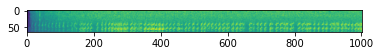

torch.Size([1001, 64]) torch.Size([2, 1, 1001, 64])


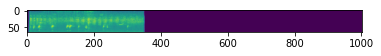

epoch = 0, loss = 0.12361157685518265


Training: 0it [00:00, ?it/s]

torch.Size([1001, 64]) torch.Size([10, 1, 1001, 64])


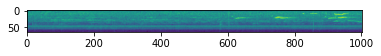

torch.Size([1001, 64]) torch.Size([10, 1, 1001, 64])


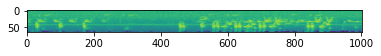

torch.Size([1001, 64]) torch.Size([10, 1, 1001, 64])


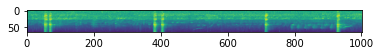

torch.Size([1001, 64]) torch.Size([10, 1, 1001, 64])


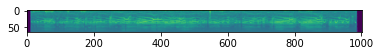

torch.Size([1001, 64]) torch.Size([10, 1, 1001, 64])


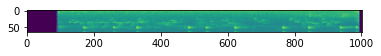

In [ ]:
torch.cuda.empty_cache()
for i, (trn_idx, val_idx) in enumerate(splitter.split(train, y=train["primary_label"])):
    if i not in CFG.folds:
        continue

    trn_df = train.loc[trn_idx, :].reset_index(drop=True)
    val_df = train.loc[val_idx, :].reset_index(drop=True)
    
    loaders = {
        phase: torchdata.DataLoader(
            WaveformDataset(
                df_,
                train_datadir,
                img_size=CFG.img_size,
                period=CFG.period,
                validation=(phase == "valid"),
                test=False
            ),
            **CFG.loader_params[phase])  # type: ignore
        for phase, df_ in zip(["train", "valid"], [trn_df, val_df])
    }
    
    num_train_steps = int(len(loaders['train']) * CFG.epochs)
    num_warmup_steps = int(num_train_steps / 10)    
    
    model = Transfer_Cnn14(sample_rate=CFG.sample_rate, window_size=CFG.n_fft, 
                           hop_size=CFG.hop_length, mel_bins=CFG.n_mels, fmin=CFG.fmin, fmax=CFG.fmax, 
                           classes_num=CFG.num_classes, freeze_base=False)
    model.load_from_pretrain(checkpoint_path)
    model_name = "Cnn_14"
    learner = Learner(model, num_train_steps, num_warmup_steps)
    
    # loggers
    RUN_NAME = f'exp{str(CFG.exp_num)}'
    wandb.init(project='BirdCLEF22-New-Experiment-PANN', entity='cknwandb', group=RUN_NAME, job_type=RUN_NAME + f'-fold-{i}')
    wandb_config = wandb.config
    wandb.watch(model)
    
    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=OUTPUT_DIR,
        verbose=False,
        filename=f'{model_name}-{learner.current_epoch}-{i}')
    callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=20,
        verbose=True,
        mode='min')
    callbacks.append(early_stop_callback)
    
    loggers = []
    loggers.append(WandbLogger())
    
    trainer = pl.Trainer(
        logger=loggers,
        callbacks=callbacks,
        max_epochs=CFG.epochs,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
        deterministic=True,
        benchmark=False
        )
    
    trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])
    trainer.save_checkpoint(OUTPUT_DIR / "last.ckpt")
    
wandb.init(project='BirdCLEF22-New-Experiment-PANN', entity='cknwandb', group=RUN_NAME, job_type='summary')
wandb.run.name = 'summary'
wandb.save('./config_.py')
wandb.finish()

## Inference

In [ ]:
# import glob
# test_audios = list(glob.glob("../input/birdclef-2022/test_soundscapes/*.ogg"))
# sample_submission = pd.read_csv('../input/birdclef-2022/sample_submission.csv')

In [ ]:
# threshold = 0.2
# new_model = ASTModel(label_dim=CFG.num_classes, 
#          input_fdim=CFG.n_mels, 
#          input_tdim=626, 
#          audioset_pretrain=True, 
#          model_size='base384', 
#          verbose=True).to(device)
# learner = Learner(model, num_train_steps, num_warmup_steps)
# checkpoint = torch.load('./last.ckpt')
# learner.load_state_dict(checkpoint['state_dict'])
# new_model = learner.model_.to(device)

In [ ]:
# for audio_path in test_audios:
#     print(audio_path)
#     seconds = []
#     row_ids = []
#     for second in range(10, 65, 10):
#         row_id = audio_path.split("/")[-1][:-4] + f"_{second}"
#         seconds.append(second)
#         row_ids.append(row_id)
#     print(row_ids)
#     test_df = pd.DataFrame({"filename": audio_path, "row_id": row_ids, "seconds": seconds})